In [1]:
%load_ext autoreload

In [2]:
autoreload 2

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import seaborn as sn

import pycollocation

## The basic model: amplification and persistance

In [7]:
# need to specify some production function for gatherers
def output(k, alpha):
    return k**alpha

def marginal_product_capital(k, alpha, **params):
    return alpha * k**(alpha - 1)

def K_dot(t, K, B, q, u, a, R):
    return (1 / u) * ((a + q) * K - R * B) - K

def B_dot(t, K, B, q, u, R):
    return (1 / R) * q * K - B

def q_dot(t, K, B, q, u, R):
          return (R - 1) * q - R * u
          
def u_dot(t, K, B, q, u, m, K_bar, R, **params):
    return (1 / R) * marginal_product_capital((1 / m) * (K_bar - K), **params) - u

def rhs(t, K, B, q, u, a, m, K_bar, R, **params):
    out = [K_dot(t, K, B, q, u, a, R),
           B_dot(t, K, B, q, u, R),
           q_dot(t, K, B, q, u, R),
           u_dot(t, K, B, q, u, m, K_bar, R, **params)]
    return out

In [82]:
def steady_state_capital(a, m, K_bar, R, alpha, **params):
    return K_bar - m * (alpha / (a * R))**(1 / (1 - alpha))

def steady_state_debt(a, m, K_bar, R, **params):
    Kstar = steady_state_capital(a, m, K_bar, R, **params)
    return (a / (R - 1)) * Kstar

def steady_state_land_price(a, R, **params):
    return (R / (R - 1)) * a
            
def steady_state_user_cost(a, **params):
    return a

def bcs_lower(t, K, B, q, u, K0, **params):
    return [K - K0]

def bcs_upper(t, K, B, q, u, a, m, K_bar, R, **params):
    Bstar = steady_state_debt(a, m, K_bar, R, **params)
    qstar = steady_state_land_price(a, R)
    ustar = steady_state_user_cost(a)
    return [B - Bstar, q - qstar, u - ustar]

In [83]:
params = {'a': 1.01, 'm': 10.0, 'alpha': 0.33, 'R': 1.5, 'K_bar': 100, 'K0': 95}

In [84]:
Kstar

98.97176708265565

In [85]:
B0

142.5

In [86]:
Bstar

199.9229695069644

In [93]:
# specify an initial guess
domain = [0, 10]
ts = np.linspace(domain[0], domain[1], 1000)
Kstar = steady_state_capital(**params)
Ks = Kstar - (Kstar - params['K0']) * np.exp(-ts)
initial_capital_poly = np.polynomial.Chebyshev.fit(ts, Ks, 5, domain)

# initial value of debt is some multiple of capital stock
B0 = 1.5 * params['K0']
Bstar = steady_state_debt(**params)
Bs = Bstar - (Bstar - B0) * np.exp(-ts) 
initial_debt_poly = np.polynomial.Chebyshev.fit(ts, Bs, 5, domain)

# starting with K0 < Kstar, must be that u0 > ustar
ustar = steady_state_user_cost(**params)
u0 = 1.5 * ustar
us = ustar - (ustar - u0) * np.exp(-ts)
initial_user_cost_poly = np.polynomial.Chebyshev.fit(ts, us, 5, domain)

# starting with K0 < Kstar, must be that q0 > qstar
qstar = steady_state_land_price(**params)
q0 = 1.05 * qstar
qs = qstar + (qstar - q0) * np.exp(-ts)
initial_land_price_poly = np.polynomial.Chebyshev.fit(ts, qs, 5, domain)

initial_coefs = np.hstack([initial_capital_poly.coef, initial_debt_poly.coef, 
                           initial_user_cost_poly.coef, initial_land_price_poly.coef])

In [94]:
nodes = pycollocation.PolynomialSolver.collocation_nodes(5, domain, "Chebyshev")

In [95]:
problem = pycollocation.TwoPointBVP(bcs_lower, bcs_upper, 1, 4, rhs, params)

In [96]:
solution = pycollocation.PolynomialSolver.solve({'kind': "Chebyshev"},
                                                initial_coefs,
                                                domain,
                                                nodes,
                                                problem)

In [99]:
pycollocation.PolynomialSolver._array_to_list(initial_coefs, 4)

[array([ 98.25192341,   1.29704214,  -0.91771876,   0.5470026 ,
         -0.25019508,   0.10814735]),
 array([ 189.51562177,   18.75236135,  -13.26818405,    7.90844809,
          -3.61726759,    1.56357157]),
 array([ 1.10152628, -0.16491558,  0.11668559, -0.06954998,  0.03181166,
        -0.01375066]),
 array([ 3.00254212,  0.04947467, -0.03500568,  0.02086499, -0.0095435 ,
         0.0041252 ])]

In [100]:
initial_capital_poly.coef

array([ 98.25192341,   1.29704214,  -0.91771876,   0.5470026 ,
        -0.25019508,   0.10814735])

In [97]:
solution.result

  status: 5
 success: False
     qtf: array([ 118.11507587,  -73.62805396,   34.42542314,   91.23327592,
        -21.58362966,  -46.31673836, -312.73178766,   49.73195376,
        -63.00744997,   17.69122132,  -29.50229648,    6.74219956,
       -130.3121271 ,   76.17524295,   -0.89808815,    1.0618052 ,
          4.798498  ,    8.7009872 ,    8.70516571,   13.22207324,
          3.44698481,   -3.86957298,   10.27331385,    4.00065662])
    nfev: 59
       r: array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan, 

In [72]:
K_hat, B_hat, q_hat, u_hat = solution.functions

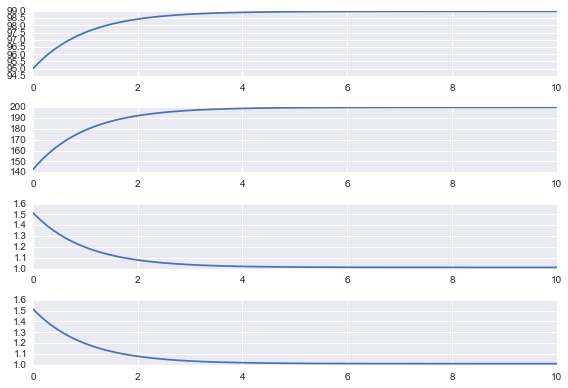

In [73]:
pts = np.linspace(domain[0], domain[1], 1000)
fig, axes = plt.subplots(4, 1)
axes[0].plot(pts, K_hat(pts))
axes[1].plot(pts, B_hat(pts))
axes[2].plot(pts, q_hat(pts))
axes[3].plot(pts, q_hat(pts))

fig.tight_layout()
plt.show()

In [74]:
K_resids, B_resids, q_resids, u_resids = solution.residuals(pts)

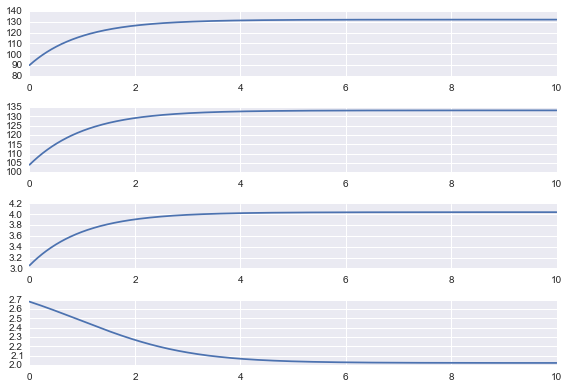

In [75]:
pts = np.linspace(domain[0], domain[1], 1000)
fig, axes = plt.subplots(4, 1)
axes[0].plot(pts, K_resids)
axes[1].plot(pts, B_resids)
axes[2].plot(pts, q_resids)
axes[3].plot(pts, u_resids)

fig.tight_layout()
plt.show()

In [10]:
basic_model_solver.solve(kind="Chebyshev",
                         coefs_dict=initial_coefs,
                         domain=domain)


In [11]:
basic_model_solver.result["success"]

True

In [12]:
basic_model_viz = pycollocation.Visualizer(basic_model_solver)

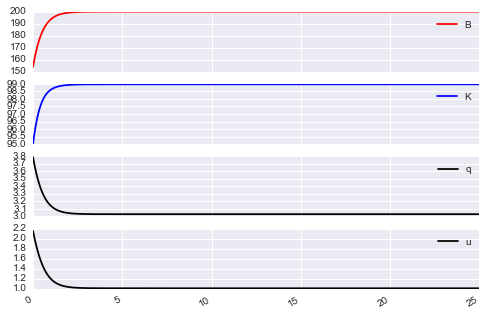

In [13]:
basic_model_viz.interpolation_knots = np.linspace(domain[0], domain[1], 1000)
basic_model_viz.solution.plot(subplots=True, style=['r', 'b'])
plt.show()

Solution is not as accurate as I would like...

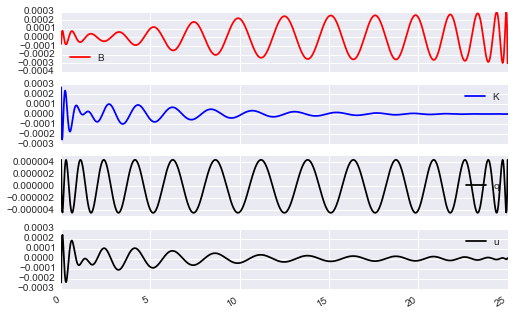

In [14]:
basic_model_viz.residuals.plot(subplots=True, style=['r', 'b'])
plt.show()

...actually, when using noramlized residuals eveything looks great!

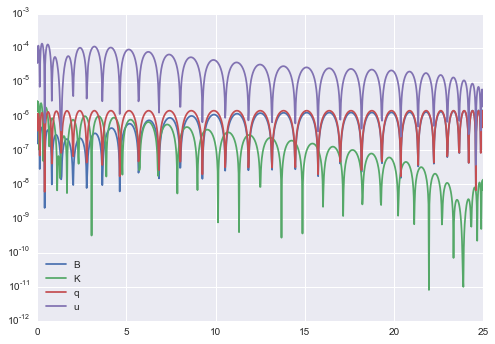

In [16]:
basic_model_viz.normalized_residuals.plot(logy=True, sharey=True)
plt.show()

In [17]:
assets = basic_model_viz.solution[['q', 'K']].prod(axis=1)
liabilities = basic_model_viz.solution.B
equity = assets - liabilities
leverage = assets / equity

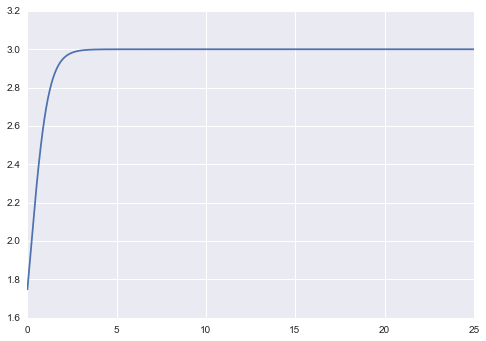

In [18]:
leverage.plot()

In [165]:
def credit_cycles(t, X, a, m, alpha, R, K_bar):
    out = np.array([(1 / X[3]) * ((a + X[2]) * X[0] - R * X[1]) - X[0], 
                    (1 / R) * X[2] * X[0] - X[1],
                    (R - 1) * X[2] - R * X[3],
                    (alpha / R) * ((1 / m) * (K_bar - X[0]))**(alpha - 1) - X[3]])
    return out

def jacobian(t, X, a, m, alpha, R, K_bar):
    out = np.array([[((a + X[2]) / X[3]) - 1.0, -R / X[3], X[0] / X[3], -X[3]**(-2)],
                    [(1 / R) * X[2], -1.0, (1 / R) * X[0], 0.0],
                    [0.0, 0.0, R - 1, -R],
                    [-(1 / m) * (alpha - 1) * (alpha / R) * ((1 / m) * (K_bar - X[0]))**(alpha - 2), 0.0, 0.0, -1.0]])
    return out

def Kstar(a, m, alpha, R, K_bar):
    return K_bar - m * (alpha / (a * R))**(1 / (1 - alpha))

def Bstar(a, m, alpha, R, K_bar):
    return (a / (R - 1)) * Kstar(a, m, alpha, R, K_bar)


In [166]:
initial_condition = np.array([Kstar(a, m, alpha, R, K_bar), Bstar(a, m, alpha, R, K_bar), (R / (R - 1)) * a, a])

In [167]:
initial_condition

array([K_bar - m*(alpha/(R*a))**(1/(-alpha + 1)),
       a*(K_bar - m*(alpha/(R*a))**(1/(-alpha + 1)))/(R - 1), R*a/(R - 1),
       a], dtype=object)

In [901]:
credit_cycles(0, initial_condition)

array([ -8.64019967e-12,   0.00000000e+00,   0.00000000e+00,
        -9.88098492e-14])

In [868]:
jacobian(0, initial_condition)

array([[  1.01000000e+02,  -9.61904762e-01,   9.52163239e+02,
         -9.07029478e-01],
       [  1.05000000e+02,  -1.00000000e+00,   9.89872674e+02,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e-02,
         -1.01000000e+00],
       [  2.15879931e+00,   0.00000000e+00,   0.00000000e+00,
         -1.00000000e+00]])

In [98]:
from scipy import linalg

In [99]:
from IPython.html.widgets import fixed, interact, FloatSliderWidget

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [170]:
def eigenvalues(a=1.0, m=1.0, alpha=0.33, R=1.05, K_bar=10.0):
    steady_state = np.array([Kstar(a, m, alpha, R, K_bar),
                             Bstar(a, m, alpha, R, K_bar),
                             (R / (R - 1)) * a,
                             a])
    vals, vecs = linalg.eig(jacobian(0, steady_state, a, m, alpha, R, K_bar))
    print vals

In [172]:
interact(eigenvalues, a=(0.0, 1e3, 1e0), m=(0.0, 1e2, 1e-1), R=(0.0, 1e2, 1e-2), K_bar=(0.0, 1e4, 1e1))

[  4.96886453e+04+86405.36943471j   4.96886453e+04-86405.36943471j
  -9.93761281e+04    +0.j           4.01197590e-08    +0.j        ]


In [1120]:
params = 2.0, 0.5, 0.33, 1.01, 500.0
problem = ivp.IVP(credit_cycles, jacobian)
problem.f_params = params
problem.jac_params = params

<h2> Full model </h2>

In [6]:
lamda, pi, phi, = sym.symbols('lamda, pi, phi')

# full model from Kiyotaki and Moore "credit-cycles" paper
K_dot = (pi / (phi + u)) * ((a + q + lamda * phi) * K - R * B) - pi * lamda * K
B_dot = (R - 1) * B + (phi * (1 - lamda) - a) * K
q_dot = (R - 1) * q - R * u
u_dot = (1 / R) * mpk.subs({k: (1 / m) * (K_bar - K)}) - u

rhs = {'K': K_dot, 'B': B_dot, 'q': q_dot, 'u': u_dot}

In [85]:
bcs = {}

ustar = ((pi * a - (1 - lamda) * (1 - R + pi * R) * phi) / 
         (lamda * pi + (1 - lamda) * (1 - R + pi * R)))
qstar = (R / (R - 1)) * ustar
Kstar = K_bar - m * (alpha / (ustar * R))**(1 / (1 - alpha))
Bstar = ((a - (1 - lamda) * phi) / (R - 1)) * Kstar

# initial conditions for K and B are given
K0 = 75
bcs['lower'] = [K - K0]

# boundary conditions on B, q and u can be written in terms of steady state values
bcs['upper'] = [B - Bstar, q - qstar, u - ustar]

In [116]:
params = {'a': 1.05, 'pi': 0.05, 'phi': 20.0, 'lamda': 0.975,'m': 1.0, 'alpha': 0.16,
          'R': 1.01, 'K_bar': 100}

In [117]:
# set up the model and solver
full_model = pycollocation.SymbolicBoundaryValueProblem(dependent_vars=['K', 'B', 'q', 'u'],
                                                        independent_var='t',
                                                        rhs=rhs,
                                                        boundary_conditions=bcs,
                                                        params=params)

full_model_solver = pycollocation.OrthogonalPolynomialSolver(full_model)

In [125]:
def Kstar(a, phi, R, alpha, pi, m, lamda, K_bar):
    return K_bar - m * (alpha / (ustar(a, phi, R, alpha, pi, m, lamda, K_bar) * R))**(1 / (1 - alpha))

def Bstar(a, phi, R, alpha, pi, m, lamda, K_bar):
    return ((a - (1 - lamda) * phi) / (R - 1)) * Kstar(a, phi, R, alpha, pi, m, lamda, K_bar)

def qstar(a, phi, R, alpha, pi, m, lamda, K_bar):
    return (R / (R - 1)) * ustar(a, phi, R, alpha, pi, m, lamda, K_bar)
            
def ustar(a, phi, R, alpha, pi, m, lamda, K_bar):
    u = ((pi * a - (1 - lamda) * (1 - R + pi * R) * phi) / 
         (lamda * pi + (1 - lamda) * (1 - R + pi * R)))
    return u

# specify an initial guess
domain = [0, 25]
ts = np.linspace(domain[0], domain[1], 1000)
Ks = Kstar(**params) - (Kstar(**params) - K0) * np.exp(-ts) * np.cos(2.0 * np.pi * ts)
initial_capital_poly = np.polynomial.Chebyshev.fit(ts, Ks, 25, domain)

# initial value of debt is some multiple of capital stock
B0 = 1.5 * K0
Bs = Bstar(**params) - (Bstar(**params) - B0) * np.exp(-ts) #* np.cos(2.0 * np.pi * ts)
initial_debt_poly = np.polynomial.Chebyshev.fit(ts, Bs, 25, domain)

# starting with K0 > Kstar, must be that u0 > ustar
us = ustar(**params) - (ustar(**params) - 1.5 * ustar(**params)) * np.exp(-ts) #* np.cos(2.0 * np.pi * ts)
initial_user_cost_poly = np.polynomial.Chebyshev.fit(ts, us, 25, domain)

# starting with K0 > Kstar, must be that q0 > qstar
qs = qstar(**params) - (qstar(**params) - 1.5 * qstar(**params)) * np.exp(-ts) #* np.cos(2.0 * np.pi * ts)
initial_land_price_poly = np.polynomial.Chebyshev.fit(ts, qs, 25, domain)

initial_coefs = {'K': initial_capital_poly.coef, 'B': initial_debt_poly.coef, 
                 'u': initial_user_cost_poly.coef, 'q': initial_land_price_poly.coef}

In [119]:
def jacobian(t, X, a, phi, R, alpha, pi, m, lamda, K_bar):
    out = np.array([[(pi / (phi + X[3])) * (a + X[2] + lamda * phi) - pi * lamda, -(pi / (phi + X[3])) * R, (pi / (phi + X[3])) * X[0], -(pi / (phi + X[3])**2) * ((a + X[2] + lamda * phi) * X[0] - R * X[1])],
                    [(R - 1) * X[1] + (phi * (1 - lamda) - a), (R - 1), 0.0, 0.0],
                    [0.0, 0.0, R - 1, -R],
                    [-(1 / m) * (alpha - 1) * (alpha / R) * ((1 / m) * (K_bar - X[0]))**(alpha - 2), 0.0, 0.0, -1.0]])
    return out

def eigenvalues(a=1.0, phi=20.0, pi=0.05, lamda=0.975, m=1.0, alpha=0.33, R=1.05, K_bar=10.0):
    steady_state = np.array([Kstar(a, phi, R, alpha, pi, m, lamda, K_bar),
                             Bstar(a, phi, R, alpha, pi, m, lamda, K_bar),
                             qstar(a, phi, R, alpha, pi, m, lamda, K_bar),
                             ustar(a, phi, R, alpha, pi, m, lamda, K_bar)])
    vals, vecs = linalg.eig(jacobian(0, steady_state, a, phi, R, alpha, pi, m, lamda, K_bar))
    print vals
    print np.absolute(vals)

In [120]:
interact(eigenvalues, a=(1.0, 2.0, 1e-2), alpha=(1e-2, 1-1e-2, 1e-2), m=(0.0, 1e2, 1e-1), R=(0.0, 1e2, 1e-2), K_bar=(0.0, 1e4, 1e1))

[-0.96239413+0.j          0.03119783+0.31974317j  0.03119783-0.31974317j
  0.05000000+0.j        ]
[ 0.96239413  0.32126158  0.32126158  0.05      ]


<function __main__.eigenvalues>

In [126]:
full_model_solver.solve(kind="Chebyshev",
                        coefs_dict=initial_coefs,
                        domain=domain)


In [127]:
full_model_solver.result["success"]

False

In [123]:
full_model_viz = pycollocation.Visualizer(full_model_solver)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x112f80b90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1130bec50>], dtype=object)

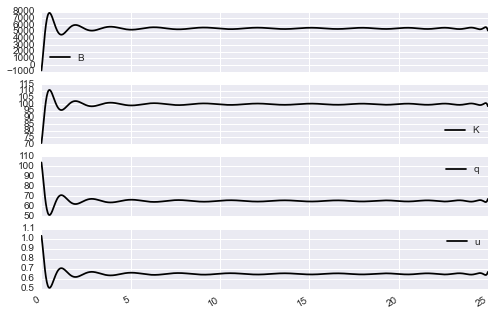

In [124]:
full_model_viz.interpolation_knots = np.linspace(domain[0], domain[1], 1000)
full_model_viz.solution.plot(subplots=True)

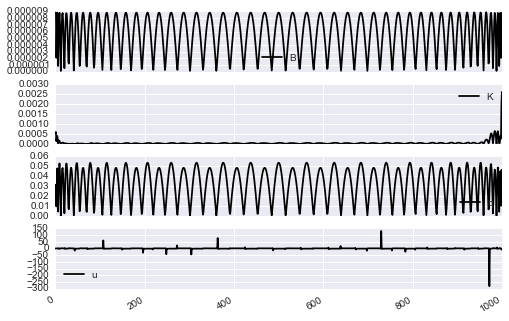

In [52]:
full_model_viz.normalized_residuals.plot(subplots=True)
plt.show()